In [2]:
import importlib
import duckdb
import random
import numpy as np

import optimized_fractals as of
importlib.reload(of) # Reload modules actively being developed

<module 'optimized_fractals' from 'c:\\Users\\aiden\\Fractals\\optimized_fractals.py'>

In [ ]:
# Generate many random set of parameters,
# Find size and surface area of results,
# Add to StartingParameters table

# Connect to database
conn = duckdb.connect("FractalData.duckdb")

iter = 0
try:
    for i in range(10000):
        # Generate parameters
        params = [0.0] * 52
        for i in range(52):
            params[i] = random.uniform(-2.0, 2.0)

        # Find surface area and size
        size, surface_area = of.coolness_raw(
            1000, 1000, .004, 
            0.0, 0.0, 
            100, 
            params 
        )

        conn.execute("INSERT INTO StartingParameters Values (" + str(size) + ", " + str(surface_area) + ", " + ", ".join([str(param) for param in params]) + ")")

        iter += 1
        print(iter, end="\r")

except:
    print("Connection closed")
    conn.close()

conn.close()


Connection closed


In [90]:
# Custom function to maximiz
def coolness_function(surface_area, size, resolution):
    return surface_area


# Define a gradient descent learning process with the hyperparameters as input
def optimize_fractal(
        starting_parameters,
        resolution, # Number of pixels wide/tall
        max_iter,   # Iterations used by coolness algorithm
        learning_rate, 
        gamma,
        epsilon,
        h,
        max_epochs):
    
    # Copy so inputs are not effected
    parameters = starting_parameters.copy()
    
    # Uses RMSprop algorithm. Sourced from: https://www.geeksforgeeks.org/machine-learning/gradient-descent-with-rmsprop-from-scratch/

    # Record all past surface areas and parameters
    coolness_trajectory = []
    temp = of.coolness_raw(
        resolution, resolution, 4.0 / resolution,
        0.0, 0.0,
        max_iter,
        starting_parameters
    )
    coolness_trajectory.append(coolness_function(temp[0],temp[1],h))

    parameter_trajectory = []
    parameter_trajectory.append(parameters.copy()) 


    e = [0.0] * 52

    derivs = [0.0] * 52

    for i in range(max_epochs):

        # print("Epoch: " + str(i), end="\r")

        # Calculate directional derivatives
        for dir in range(52):
            derivs[dir] = coolness_deriv(parameters, resolution, max_iter, dir, h)

        # Update e
        for dir in range(52):
            e[dir] = gamma * e[dir] + (1 - gamma) * derivs[dir]**2.0

        # Update parameters
        for dir in range(52):
            parameters[dir] = parameters[dir] + learning_rate * derivs[dir] / (np.sqrt(e[dir] + epsilon))

        # Record new parameters and coolness
        parameter_trajectory.append(parameters.copy())

        temp = of.coolness_raw(
            resolution, resolution, 4.0 / resolution,
            0.0, 0.0,
            max_iter,
            parameters
        )
        coolness_trajectory.append(coolness_function(temp[0], temp[1], resolution))

    return parameter_trajectory, coolness_trajectory




# Find directional derivative of surface area at given parameters
def coolness_deriv(
        parameters, 
        resolution, max_iter, # How to run coolness_raw
        direction, # Index of parameter to find derivative of
        h):
    
    # Increase parameter by h
    parameters[direction] += h

    # f(x+h)
    forward = of.coolness_raw(
        resolution, resolution, 4.0 / resolution,
        0.0, 0.0,
        max_iter,
        parameters
    )
    forwardCoolness = coolness_function(forward[0], forward[1], resolution)

    # Decrease parameter by 2h
    parameters[direction] -= 2*h

    # f(x-h)
    backward = of.coolness_raw(
        resolution, resolution, 4.0 / resolution,
        0.0, 0.0,
        max_iter,
        parameters
    )
    backwardCoolness = coolness_function(backward[0], backward[1], resolution)

    # Put parameters back to starting value
    parameters[direction] += h
    
    # Don't do typical derivative calculation because coolness function is discrete ugh
    # So no divide by 2h
    return forwardCoolness - backwardCoolness
    


In [ ]:
# Custom gradient descent algo
# Each iteration parameters by magnitude step_size
# h is the length used for finding partial derivatives 
def custom_optimize_fractals(
        starting_parameters,
        step_size,
        h,
        resolution,
        max_iter,
        max_epochs):
    
    parameters = starting_parameters.copy()
    current_coolness = of.coolness_raw(
        resolution, resolution, 4.0 / resolution,
        0.0, 0.0,
        max_iter,
        parameters)[0]
    
    parameter_history = [parameters]
    coolness_history = [current_coolness]
    
    partials = [0.0] * 52

    for i in range(max_epochs):

        print(i, end="\r")

        # Find all partials
        for dir in range(52):
            parameters[dir] += h
            partials[dir] = of.coolness_raw(resolution, resolution, 4.0 / resolution, 0.0, 0.0, max_iter, parameters)[0] - current_coolness
            parameters[dir] += -h

        # Find total magnitude of partials
        magnitude = float(np.sqrt(sum([partial*partial for partial in partials])))

        # Change each parameter by the step-size adjusted for their partials
        for dir in range(52):
            parameters[dir] += step_size * partials[dir] / magnitude

        # Record new parameters
        parameter_history.append(parameters.copy())

        # Find new coolness and record it
        current_coolness = of.coolness_raw(resolution, resolution, 4.0 / resolution, 0.0, 0.0, max_iter, parameters)[0]

        coolness_history.append(current_coolness)


    return (coolness_history, parameter_history)


# Takes an input list of parameters, runs custom_optimize_fractals on each of them for max_epochs
# Stores all results and picks the top n, where n is the size of the input list
def batch_optimize(
    parameter_list,
    out_length,
    step_size,
    h,
    resolution,
    max_iter,
    max_epochs
    ):

    all_parameters = []
    all_coolness = []

    for parameters in parameter_list:

        optimized = custom_optimize_fractals(parameters, step_size, h, resolution, max_iter, max_epochs)
        all_coolness += optimized[0]
        all_parameters += optimized[1]

    topN = [0] * len(out_length)
    topNIndexes = [0] * len(out_length)

    for i in range(len(all_parameters)):

        for j in range(len(topN)):

            if all_coolness[i] > topN[j]:
                topN.insert(j, all_coolness[i])
                topN.pop()
                topNIndexes.insert(j, i)
                topNIndexes.pop()
                break

    return [all_parameters[index] for index in topNIndexes]






In [134]:
new_parameter_list = batch_optimize([list(parameters) for parameters in top_parameters], 0.1, 0.001, 1024, 50, 50)

for i in range(5):
    new_parameter_list = batch_optimize(new_parameter_list, 0.1**(i+1), 0.001, 1024, 50, 50)


In [136]:
resolution = 1024

for parameters in new_parameter_list:

    print(of.coolness_raw(resolution, resolution, 4.0 / resolution, 0.0, 0.0, 50, parameters)[0])

5070
5070
4836
4836
5052
5052
4880
4880
5046
5046


In [137]:
new_parameter_list

[[-0.5862048588334179,
  -0.23601687572127608,
  0.0487449597142344,
  0.17241686173186457,
  0.08285776904599078,
  -1.1430854394077987,
  0.01643802788470304,
  -1.7865498656887353,
  -1.7666571075495405,
  -1.3872404175999051,
  1.0174952432005009,
  -1.404786363224868,
  1.2757103068478897,
  -1.6071186703721314,
  1.0464707346307531,
  0.568133055528281,
  -0.626311331847256,
  0.8673661927660722,
  -1.362196173158393,
  1.411293199775443,
  1.2273118269917562,
  0.14757702772228723,
  -1.3447645732274147,
  -1.3725882127841211,
  -1.4290181042157493,
  -1.1373695839110851,
  -0.7958438260491586,
  1.4954071829562916,
  -0.3400011162159261,
  -0.82188726568411,
  1.825393016871089,
  0.012431209032206436,
  1.8881469954596173,
  -0.8616268011648193,
  -1.0633128474191458,
  0.05920689063578431,
  -0.5550731753825624,
  0.6478554851977125,
  -1.355793460646242,
  -0.2815354384262929,
  -2.0706194264518736,
  -1.6907577527389765,
  1.1054272415911233,
  -0.8034578696298456,
  1.9407

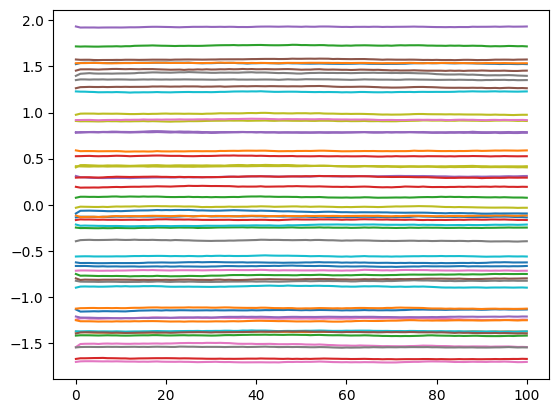

In [122]:
for i in range(52):
    plt.plot([val[i] for val in optimization[1]])

plt.show()

In [124]:
# Find the fractals with the highest surface area
conn = duckdb.connect("FractalData.duckdb")
top_parameters = conn.execute("SELECT * EXCLUDE(surface_area, size) FROM StartingParameters ORDER BY surface_area DESC LIMIT 10").fetchall()
conn.close()

top_parameters

[(-0.13127095997333527,
  -0.13507632911205292,
  0.08826321363449097,
  0.18505339324474335,
  0.7872828245162964,
  1.4679465293884277,
  -1.22981858253479,
  -0.8349721431732178,
  -0.020906880497932434,
  -0.8880430459976196,
  -0.06368594616651535,
  -1.3850735425949097,
  -1.415504813194275,
  0.5263830423355103,
  0.2997237741947174,
  -0.814943790435791,
  -1.5102081298828125,
  1.4188162088394165,
  0.428442120552063,
  -1.3713245391845703,
  -1.157423734664917,
  -1.1203595399856567,
  1.7142281532287598,
  0.29640793800354004,
  1.9213531017303467,
  1.274214267730713,
  -1.696335792541504,
  -1.5434949398040771,
  0.9033560156822205,
  -0.5580819845199585,
  -0.6315800547599792,
  -1.2617247104644775,
  -0.7705010175704956,
  -0.1578785479068756,
  0.7821001410484314,
  -1.3834794759750366,
  0.9178332090377808,
  -0.38384130597114563,
  0.9846835136413574,
  1.2254878282546997,
  1.5350605249404907,
  0.5811446309089661,
  -0.25426235795021057,
  -1.6644091606140137,
  -1.

In [5]:
conn.close()